In [1]:
import pandas as pd   
import numpy as np   
import pandas.io.data as web   
from datetime import datetime   
import scipy as sp   
import scipy.optimize as scopt   
import scipy.stats as spstats   
import matplotlib.pyplot as plt   
import matplotlib.mlab as mlab   

%matplotlib inline   
pd.set_option('display.notebook_repr_html', False)   
pd.set_option('display.max_columns', 7)   
pd.set_option('display.max_rows', 10)    
pd.set_option('display.width', 82)    
pd.set_option('precision', 3)

/home/tom/anaconda2/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
def create_portfolio(tickers, weights=None):       
    if (weights is None):            
        shares = np.ones(len(tickers))/len(tickers)       
    portfolio = pd.DataFrame({'Tickers': tickers,'Weights': weights}, index=tickers)       
    return portfolio

In [3]:
portfolio = create_portfolio(['Stock A', 'Stock B'],[1, 1])   
portfolio

         Tickers  Weights
Stock A  Stock A        1
Stock B  Stock B        1

In [4]:
returns = pd.DataFrame({'Stock A': [0.1, 0.24, 0.05, -0.02, 0.2],  'Stock B': [-0.15, -0.2, -0.01, 0.04, -0.15]})   
returns

   Stock A  Stock B
0     0.10    -0.15
1     0.24    -0.20
2     0.05    -0.01
3    -0.02     0.04
4     0.20    -0.15

In [5]:
# Create Weighted Portfolio
def calculate_weighted_portfolio_value(portfolio, returns, name='Value'):
    total_weights = portfolio.Weights.sum()
    weighted_returns = returns * (portfolio.Weights / total_weights)       
    return pd.DataFrame({name: weighted_returns.sum(axis=1)})

In [12]:
wr = calculate_weighted_portfolio_value(portfolio, returns, "Return of Weighted Portfolio")   
with_value = pd.concat([returns, wr], axis=1)   
with_value

   Stock A  Stock B  Return of Weighted Portfolio
0     0.10    -0.15                        -0.025
1     0.24    -0.20                         0.020
2     0.05    -0.01                         0.020
3    -0.02     0.04                         0.010
4     0.20    -0.15                         0.025

In [13]:
#calculate volatility
with_value.std()

Stock A                         0.107
Stock B                         0.103
Return of Weighted Portfolio    0.020
dtype: float64

In [14]:
'''
notice above
Stock A had a volatility of 11 percent and Stock B of 10 percent. The combined portfolio 
represented significantly lower volatility of 2 percent. This is because we picked two 
negatively correlated stocks with similar volatility and combining them has therefore 
reduced the overall risk.
'''

'\nnotice above\nStock A had a volatility of 11 percent and Stock B of 10 percent. The combined portfolio \nrepresented significantly lower volatility of 2 percent. This is because we picked two \nnegatively correlated stocks with similar volatility and combining them has therefore \nreduced the overall risk.\n'

In [15]:
def plot_portfolio_returns(returns, title=None):       
    returns.plot(figsize=(12,8))       
    plt.xlabel('Year')       
    plt.ylabel('Returns')       
    if (title is not None): 
        plt.title(title)       
    plt.show()

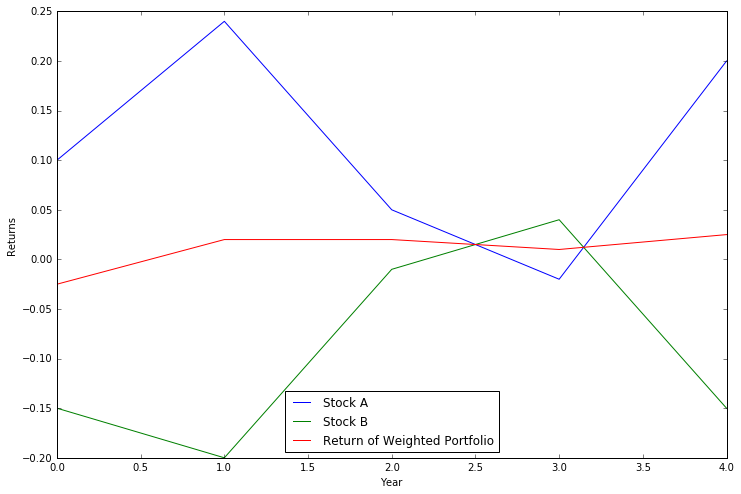

In [16]:
plot_portfolio_returns(with_value)

In [17]:
# Check correlations between stocks
# Correlation btw Stock A and Stock B almost perfectly negatively correlated
returns.corr()

         Stock A  Stock B
Stock A    1.000   -0.926
Stock B   -0.926    1.000

In [18]:
def get_historical_closes(ticker, start_date, end_date):       
    p = web.DataReader(ticker, "yahoo", start_date, end_date)           
    d = p.to_frame()['Adj Close'].reset_index()       
    d.rename(columns={'minor': 'Ticker', 'Adj Close': 'Close'}, inplace=True)       
    pivoted = d.pivot(index='Date', columns='Ticker')       
    pivoted.columns = pivoted.columns.droplevel(0)       
    return pivoted

In [20]:
closes = get_historical_closes(['MSFT', 'AAPL', 'KO'], '2010-01-01', '2014-12-31')

In [21]:
closes[:5]

Ticker        AAPL      KO    MSFT
Date                              
2010-01-04  27.990  23.319  25.884
2010-01-05  28.039  23.037  25.892
2010-01-06  27.593  23.029  25.734
2010-01-07  27.542  22.971  25.466
2010-01-08  27.725  22.546  25.642

In [22]:
def calc_daily_returns(closes):       
    return np.log(closes/closes.shift(1))

In [23]:
daily_returns = calc_daily_returns(closes)   
daily_returns[:5]

Ticker       AAPL         KO       MSFT
Date                                   
2010-01-04    NaN        NaN        NaN
2010-01-05  0.002 -1.217e-02  3.230e-04
2010-01-06 -0.016 -3.549e-04 -6.156e-03
2010-01-07 -0.002 -2.488e-03 -1.045e-02
2010-01-08  0.007 -1.868e-02  6.873e-03

In [28]:
def calc_annual_returns(daily_returns):       
    grouped = np.exp(daily_returns.groupby(lambda date: date.year).sum())-1       
    return grouped

In [29]:
annual_returns = calc_annual_returns(daily_returns)   
annual_returns

Ticker   AAPL     KO   MSFT
2010    0.507  0.189 -0.079
2011    0.256  0.095 -0.045
2012    0.326  0.065  0.058
2013    0.081  0.172  0.443
2014    0.406  0.053  0.276

In [30]:
def calc_portfolio_var(returns, weights=None):       
    if (weights is None):            
        weights = np.ones(returns.columns.size) / returns.columns.size       
    sigma = np.cov(returns.T,ddof=0)       
    var = (weights * sigma * weights.T).sum()       
    return var   

In [31]:
calc_portfolio_var(annual_returns)

0.0028795409974699615

In [37]:
annual_returns.T

         2010   2011   2012   2013   2014
Ticker                                   
AAPL    0.507  0.256  0.326  0.081  0.406
KO      0.189  0.095  0.065  0.172  0.053
MSFT   -0.079 -0.045  0.058  0.443  0.276

In [36]:
sigma = np.cov(annual_returns.T,ddof=0)  


array([[  2.07627378e-02,  -8.28493561e-04,  -1.81331198e-02],
       [ -8.28493561e-04,   3.11846779e-03,   8.89961508e-05],
       [ -1.81331198e-02,   8.89961508e-05,   3.97798978e-02]])

In [38]:
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.015):       
    n = returns.columns.size       
    if weights is None: 
        weights = np.ones(n)/n       
    var = calc_portfolio_var(returns, weights)       
    means = returns.mean()       
    return (means.dot(weights) - risk_free_rate)/np.sqrt(var)

In [39]:
sharpe_ratio(annual_returns)

3.2010926488651599

In [40]:
# Quick example of how minimization works (minimum value for func is 2 when x=0)
def y_f(x): return 2+x**2
scopt.fmin(y_f, 1000)      # 1000 is seed value for x

Optimization terminated successfully.
         Current function value: 2.000000
         Iterations: 27
         Function evaluations: 54


array([ 0.])

In [41]:
# Need to maximize Sharpe ratio.  To do this iwth a minimize algo, we need to create a func to return neg Sharpe
# Minimize functions will provide best values for function parameters
def negative_sharpe_ratio_n_minus_1_stock(weights, returns, risk_free_rate):       
    """       
    Given n-1 weights, return a negative sharpe ratio       
    """       
    weights2 = sp.append(weights, 1-np.sum(weights))       
    return -sharpe_ratio(returns, weights2, risk_free_rate)

In [42]:
def optimize_portfolio(returns, risk_free_rate):       
    w0 = np.ones(returns.columns.size-1, dtype=float) * 1.0 / returns.columns.size       
    w1 = scopt.fmin(negative_sharpe_ratio_n_minus_1_stock, w0, args=(returns, risk_free_rate))       
    final_w = sp.append(w1, 1 - np.sum(w1))       
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)       
    return (final_w, final_sharpe)

In [43]:
optimize_portfolio(annual_returns, 0.0003)

Optimization terminated successfully.
         Current function value: -7.829861
         Iterations: 46
         Function evaluations: 89


(array([ 0.76353353,  0.2103234 ,  0.02614307]), 7.829861388697041)

In [44]:
def objfun(W, R, target_ret):       
    stock_mean = np.mean(R,axis=0)       
    port_mean = np.dot(W,stock_mean)        
    cov=np.cov(R.T)        
    port_var = np.dot(np.dot(W,cov),W.T)        
    penalty = 2000*abs(port_mean-target_ret)       
    return np.sqrt(port_var) + penalty 

In [45]:
def calc_efficient_frontier(returns):       
    result_means = []       
    result_stds = []       
    result_weights = []           
    means = returns.mean()       
    min_mean, max_mean = means.min(), means.max()           
    nstocks = returns.columns.size           
    for r in np.linspace(min_mean, max_mean, 100):           
        weights = np.ones(nstocks)/nstocks           
        bounds = [(0,1) for i in np.arange(nstocks)]           
        constraints = ({'type': 'eq',  'fun': lambda W: np.sum(W) - 1})           
        results = scopt.minimize(objfun, weights, (returns, r), method='SLSQP', constraints = constraints, bounds = bounds)           
        if not results.success: 
            # handle error 
            raise Exception(result.message)           
        result_means.append(np.round(r,4)) # 4 decimal places           
        std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)           
        result_stds.append(std_)                   
        result_weights.append(np.round(results.x, 5))   
    return {'Means': result_means, 'Stds': result_stds, 'Weights': result_weights}

In [46]:
frontier_data = calc_efficient_frontier(annual_returns)

In [47]:
frontier_data

{'Means': [0.1148,
  0.1169,
  0.11890000000000001,
  0.12089999999999999,
  0.1229,
  0.125,
  0.127,
  0.129,
  0.13100000000000001,
  0.13300000000000001,
  0.1351,
  0.1371,
  0.1391,
  0.1411,
  0.14319999999999999,
  0.1452,
  0.1472,
  0.1492,
  0.15129999999999999,
  0.15329999999999999,
  0.15529999999999999,
  0.1573,
  0.1593,
  0.16139999999999999,
  0.16339999999999999,
  0.16539999999999999,
  0.16739999999999999,
  0.16950000000000001,
  0.17150000000000001,
  0.17349999999999999,
  0.17549999999999999,
  0.17749999999999999,
  0.17960000000000001,
  0.18160000000000001,
  0.18360000000000001,
  0.18559999999999999,
  0.18770000000000001,
  0.18970000000000001,
  0.19170000000000001,
  0.19370000000000001,
  0.19570000000000001,
  0.1978,
  0.19980000000000001,
  0.20180000000000001,
  0.20380000000000001,
  0.2059,
  0.2079,
  0.2099,
  0.21190000000000001,
  0.21390000000000001,
  0.216,
  0.218,
  0.22,
  0.222,
  0.22409999999999999,
  0.2261,
  0.2281,
  0.2301,
  0

In [48]:
frontier_data['Means'][:5]

[0.1148, 0.1169, 0.11890000000000001, 0.12089999999999999, 0.1229]

In [49]:
frontier_data['Stds'][:5]

[0.055842999999999997, 0.053446, 0.052564, 0.051706000000000002, 0.050871]

In [61]:
# Minimum Variance Portfolio is found by identifying the index of the lowest variance datapoint
# Use that index to find the associated weights
x=frontier_data['Stds'].index(min(frontier_data['Stds']))
frontier_data['Weights'][x]

array([ 0.24075,  0.60769,  0.15156])

In [50]:
frontier_data['Weights'][:5]

[array([ 0.,  1.,  0.]),
 array([ 0.00512,  0.9308 ,  0.06407]),
 array([ 0.01497,  0.9177 ,  0.06733]),
 array([ 0.02469,  0.90303,  0.07228]),
 array([ 0.03458,  0.89049,  0.07493])]

In [51]:
def plot_efficient_frontier(ef_data):       
    plt.figure(figsize=(12,8))       
    plt.title('Efficient Frontier')       
    plt.xlabel('Standard Deviation of the porfolio (Risk))')       
    plt.ylabel('Return of the portfolio')       
    plt.plot(ef_data['Stds'], ef_data['Means'], '--');  

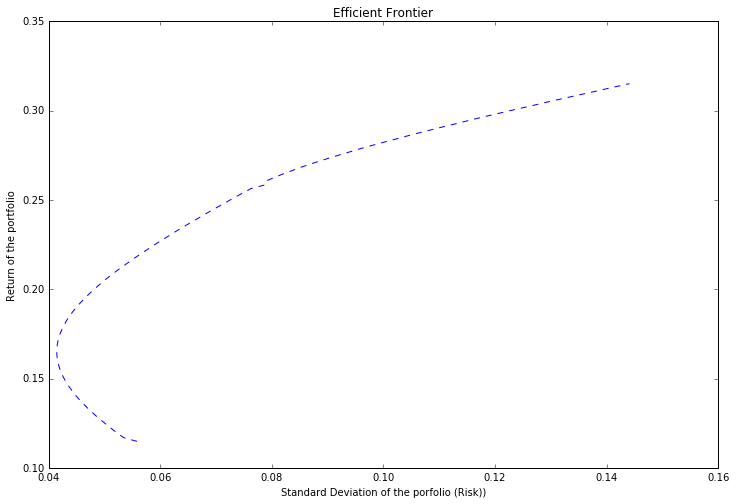

In [52]:
plot_efficient_frontier(frontier_data)

14.400000000000002